In [1]:
import monai
import numpy as np
import medmnist
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:


train_dataset = medmnist.dataset.OrganMNIST3D(split="train", download=True, size=64)
val_dataset = medmnist.dataset.OrganMNIST3D(split="val", download=True, size=64)
test_dataset = medmnist.dataset.OrganMNIST3D(split="test", download=True, size=64)

Using downloaded and verified file: /home/suraj/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /home/suraj/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /home/suraj/.medmnist/organmnist3d_64.npz


In [3]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /home/suraj/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

In [4]:
label_map = {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}

In [5]:
dataset = train_dataset + val_dataset + test_dataset

In [6]:
# dataset = monai.data.DatasetFunc(
#     data=dataset,
#     func=lambda dataset: [{'input': torch.tensor(item[0].astype(np.float32).transpose(0, 3, 2, 1)), 'target': torch.tensor(item[1][0])} for item in dataset]
# )

dataset = monai.data.DatasetFunc(
    data=dataset,
    func=lambda dataset: [{'input': torch.tensor(np.flip(item[0].astype(np.float32), axis=[2, 1]).copy()), 'target': torch.tensor(item[1][0])} for item in dataset]
)

In [7]:
import matplotlib.pyplot as plt

def plot_3d_image(ret):
    # Plot axial slice
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.imshow(ret[:, ret.shape[1] // 2, :, :].permute(1, 2, 0), cmap="gray")
    plt.title("Axial")
    plt.axis("off")

    # Plot sagittal slice
    plt.subplot(3, 1, 2)
    plt.imshow(ret[:, :, ret.shape[2] // 2, :].permute(1, 2, 0), cmap="gray")
    plt.title("Coronal")
    plt.axis("off")

    # Plot coronal slice
    plt.subplot(3, 1, 3)
    plt.imshow(ret[:, :, :, ret.shape[3] // 2].permute(1, 2, 0), cmap="gray")
    plt.title("Sagittal")

    plt.axis("off")
    plt.show()


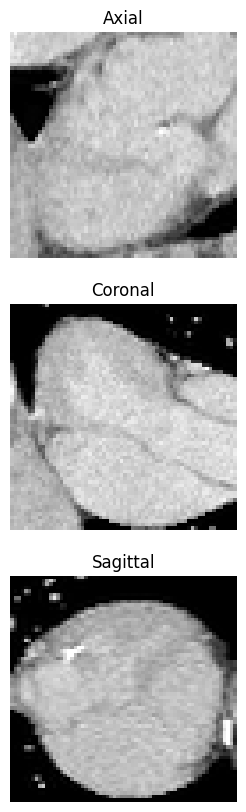

tensor(6)


In [8]:
idx = 26
plot_3d_image(dataset[idx]['input'])
print(dataset[idx]['target'])

In [9]:
import torch
from monai.networks.nets.segresnet_ds import SegResEncoder

weights = torch.load("/mnt/data1/CT_FM/latest_fm_checkpoints/pretrained_segresnet.torch", map_location=torch.device('cpu'))
weights = {k.replace('encoder.', ''): v for k, v in weights.items()}

model = SegResEncoder(
    blocks_down=(1, 2, 2, 4, 4),
    head_module=lambda x: torch.nn.functional.adaptive_avg_pool3d(x[-1], 1).flatten(start_dim=1) # Get only the last feature across block levels and average pool it. 
)

model.load_state_dict(weights, strict=False) # Set strict to False as we load only the encoder
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


SegResEncoder(
  (conv_init): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (layers): ModuleList(
    (0): ModuleDict(
      (blocks): Sequential(
        (0): SegResBlock(
          (norm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
          (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (downsample): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    )
    (1): ModuleDict(
      (blocks): Sequential(
        (0): SegResBlock(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [10]:
# import sys
# sys.path.append('/home/suraj/Repositories/lighter-ct-fm')

# from models.suprem import SuPreM_loader
# from models.backbones.unet3d import UNet3D

# model = torch.nn.Sequential(
# SuPreM_loader(
#     model=UNet3D(n_class=11),
#     ckpt_path="/mnt/data1/CT_FM/baselines/SuPreM_UNet/supervised_suprem_unet_2100.pth",
#     decoder=False,
#     encoder_only=True,
#     device=torch.device('cpu')
# ),
#     torch.nn.AdaptiveAvgPool3d(1),
#     torch.nn.Flatten(start_dim=1)
# )

# model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loading SuPreM UNet backbone pretrained weights
Loaded 56/106 keys


Sequential(
  (0): Encoder(
    (model): UNet3D(
      (down_tr64): DownTransition(
        (ops): Sequential(
          (0): LUConv(
            (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (bn1): ContBatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU(inplace=True)
          )
          (1): LUConv(
            (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU(inplace=True)
          )
        )
        (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (down_tr128): DownTransition(
        (ops): Sequential(
          (0): LUConv(
            (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (bn1): ContBatchNorm3d(64,

In [11]:
# Test I/O
model(dataset[idx]['input'].unsqueeze(0)).shape

torch.Size([1, 512])

In [12]:
dataloader = monai.data.DataLoader(
    dataset,
    batch_size=32,
    num_workers=8
)

In [13]:
import gc
import torch

model_dict = {
    "pred": [],
    "target": []
}
count = 0
for batch in dataloader:
    with torch.no_grad():
        pred = model(batch['input']).cpu().numpy()
    model_dict['pred'].extend(pred)
    model_dict['target'].extend(batch['target'])
    gc.collect()

In [14]:
len(model_dict['pred'])

1742

In [15]:
pred = np.concatenate([np.expand_dims(v, axis=0) for v in model_dict['pred']], axis=0)
target = np.array([v for v in model_dict['target']])

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import pandas as pd

# Convert pred tensor to numpy array if it's not already
pred_np = pred.numpy() if isinstance(pred, torch.Tensor) else pred

# Initialize t-SNE and fit_transform the data
feat_extractor = TSNE(n_components=2, random_state=42, perplexity=100)
# pred = feat_extractor.fit_transform(pred_np)

# Normalize the data before applying PCA
# feat_extractor = PCA(n_components=2, random_state=42)
# scaler = StandardScaler()
# pred_np_normalized = scaler.fit_transform(pred_np)
feat_pred = feat_extractor.fit_transform(pred_np)

# Define the label map
label_map = {0: 'liver', 1: 'kidney-right', 2: 'kidney-left', 3: 'femur-right', 4: 'femur-left', 
             5: 'bladder', 6: 'heart', 7: 'lung-right', 8: 'lung-left', 9: 'spleen', 10: 'pancreas'}

# Map target values to labels
target_labels = [label_map[t] for t in target]

# Create a DataFrame for plotly
df = pd.DataFrame({
    'Dimension 1': feat_pred[:, 0],
    'Dimension 2': feat_pred[:, 1],
    'Target': target_labels
})

# Sort the unique labels based on the order in label_map
sorted_labels = sorted(df['Target'].unique(), key=lambda x: list(label_map.values()).index(x))




In [26]:
# Convert plt.cm.tab20.colors to hex
color_hex = ['#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)) for r, g, b in plt.cm.tab20.colors]

# Select one point for each target label
df_annotate = df.groupby('Target').last().reset_index()

# Plot the t-SNE results using plotly express
fig = px.scatter(df, x='Dimension 1', y='Dimension 2', color='Target',
                 color_discrete_sequence=color_hex,
                 category_orders={'Target': sorted_labels})

# Add annotations for the selected points
for _, row in df_annotate.iterrows():
    fig.add_annotation(
        x=row['Dimension 1'],
        y=row['Dimension 2'],
        text=row['Target'],
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=2,
        arrowcolor="#636363",
        ax=20,
        ay=-30,
        bordercolor="#c7c7c7",
        borderwidth=2,
        borderpad=4,
        bgcolor="#f0f0f0",
        opacity=0.8
    )

fig.update_traces(marker=dict(size=10, opacity=0.5, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    plot_bgcolor='white',
    width=800, height=800,  # Increased size to accommodate annotations
    margin=dict(l=40, r=40, t=40, b=40),
    showlegend=True
)
fig.show()